# Rovnice mělké vody

## Případ s rovným dnem v 1D

Předpoklady:
 - konstantní šířka kanálu $L$,
 - konstantní hustota $\rho$,
 - rychlost $u$ závisí pouze na $x$ a $t$ (je tedy v celém průřezu stejná),
 - výška hladiny $h$ nad dnem ($z=0$) závisí pouze na $x$ a $t$ (je tedy po celé šířce kanálu stejná),
 - pohyb je bez tření,
 - konstantní tíhové zrychlení $g$
 
Hmotnost tekutiny mezi $x_1$ a $x_2$:
$$
    m_{12}(t) = \int_{x_1}^{x_2} \rho L h(x,t) \, dx,
$$

Bilance hmoty (změna hmotnosti = přítok - odtok):
$$
    \dot{m}_{12}(t) = \rho L h(x_1,t) u(x_1,t) - \rho L h(x_2,t) u(x_2,t)
$$
neboli v diferenciálním tvaru
$$
    \frac{\partial h}{\partial t} + \frac{\partial (hu)}{\partial x} = 0.
$$

Hybnost tekutiny mezi $x_1$ a $x_2$:
$$
    i_{12}(t) = \int_{x_1}^{x_2} \rho L h(x,t) u(x,t) \, dx,
$$

Hydrostatická síla působicí v bodě $x$
$$
    F_h(x,t) = \int_{0}^{h(x,t)} \rho L g z \,dz = \frac{1}{2} \rho L g h^{2}(x,t)
$$

Bilance hybnosti(změna hybnosti = přítok - odtok + rozdíl hydrostatických sil):
$$
    \dot{i}_{12}(t) = \rho L h(x_1,t) u(x_1,t) - \rho L h(x_2,t) u(x_2,t) 
    + \frac{1}{2} \rho L g h^{2}(x_1,t) - \frac{1}{2} \rho L g h^{2}(x_2,t)
$$
neboli v diferenciálním tvaru
$$
    \frac{\partial (hu)}{\partial t} + \frac{\partial (hu^2+gh^2/2)}{\partial x} = 0.
$$


### Rovnice popisující proudění mělké vody v 1D
\begin{align*}
    \frac{\partial h}{\partial t} + \frac{\partial (hu)}{\partial x} &= 0, \\
    \frac{\partial (hu)}{\partial t} + \frac{\partial (hu^2+gh^2/2)}{\partial x} &= 0.
\end{align*}


In [3]:
from sympy import *
init_printing(use_unicode=True)

In [4]:
h, q, u, g = symbols('h q u g')

In [5]:
W=[h,q]

In [6]:
F=[q,q**2/h + g*h**2/2]

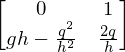

In [7]:
A=Matrix([[diff(F[0],h), diff(F[0],q)],[diff(F[1],h), diff(F[1],q)]])
A

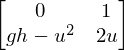

In [8]:
A=A.subs(q,h*u)
A

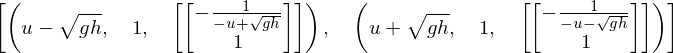

In [9]:
eigen=A.eigenvects()
eigen

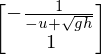

In [10]:
r1=eigen[0][2][0]
r1

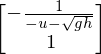

In [11]:
r2=eigen[1][2][0]
r2

**Věta** Systém rovnic popisující pohyb mělké vody je hyperbolický právě tehdy, když $h>0$.

## Simulace problému protržení hráze

Uvažujeme počáteční problém popsaný rovnicemi pro pohyb mělké vody v 1D. Jako počáteční podmínku uvažujeme stav s nulovou rychlostí ($u=0$) a s hladinou o výšce
$$
    h(x,0) = \left\{
    \begin{array}{ll}
        1 & \text{pro } x < 0.5, \\
        0.01 & \text{pro } x \ge 0.5.
    \end{array}
    \right.
$$

In [12]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

plt.rcParams["figure.figsize"] = (10,4)

In [13]:
n = 200
dx = 1.0 / n
x = np.linspace(dx/2,1-dx/2,n)

In [14]:
# Initial condition
u =  np.array([ 0.0 for xi in x ])
h = np.array([(1.1 if xi<0.5 else 0.01) for xi in x])
g = 10.0

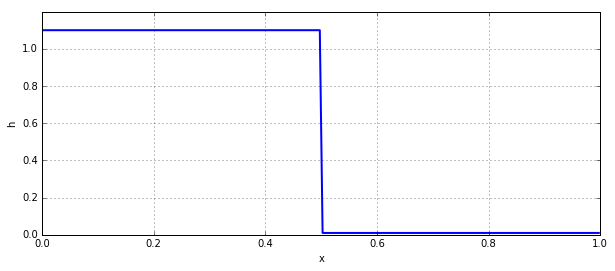

In [15]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 1)); ax.set_ylim((0, 1.2))
ax.set_xlabel("x");   ax.set_ylabel("h")
ax.grid(True)
lineh, = ax.plot(x, h, lw=2)


In [16]:
H_ = 0
HU_ = 1

def eigen(W):
    h  = W[H_]
    hu = W[HU_]
    u  = hu / h
    a  = sqrt(g*h)
    return u - a, u + a
    
def sigma(W):
    eig = eigen(W)
    return max(abs(eig[0]),abs(eig[1]))

def flux(W):
    h  = W[H_]
    hu = W[HU_]
    u  = hu / h
    return np.array([ hu, hu*u + 0.5*g*h**2])
    
def HLL(Wl, Wr):
    Fl = flux(Wl)
    Fr = flux(Wr)
    
    eigl = eigen(Wl)
    eigr = eigen(Wr)
    sl = min(eigl[0], eigr[0])
    sr = max(eigl[1], eigr[1])
    
    if 0.0 <= sl:
        return Fl
    elif 0.0 < sr:
        return (sr*Fl - sl*Fr + sl*sr*(Wr-Wl)) / (sr - sl)
    else:
        return Fr

In [17]:
W = np.array([h, h*u])

In [18]:
sigma(W[:,0])

In [19]:
flux(W[:,0])

array([ 0.  ,  6.05])

In [20]:
F = zeros(2,n+1)
W = np.array([h, h*u])

def init():
    lineh.set_data(x, h)
    return (lineh,)

def animate(it):
    dt = 1.e16
    for i in range(n):
        dt = min(dt, 0.8 * dx / sigma(W[:,i]))
    
    F[:,0] = HLL(W[:,0],W[:,0])
    F[:,-1] = HLL(W[:,-1],W[:,-1])
    for i in range(n-1):
        F[:,i+1] = HLL(W[:,i],W[:,i+1])
    
    for i in range(n):
        for k in range(2):
            W[k,i] = W[k,i] - dt / dx * (F[k,i+1]-F[k,i])
        
    lineh.set_data(x, W[H_,:])
    return (lineh,)

#animate(0)
W[1,1] = F[1,1]

In [21]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=150, interval=50, blit=True, repeat=False)

In [22]:
HTML(anim.to_html5_video())

## Případ se zadaným tvarem dna

Tvar dna je dán funkcí $b(x)$. Veličina $h$ je výška hladiny nad dnem. Pohyb mělké vody je pak popsán rovnicemi
\begin{align*}
    \frac{\partial h}{\partial t} + \frac{\partial (hu)}{\partial x} &= 0, \\
    \frac{\partial (hu)}{\partial t} + \frac{\partial (hu^2+gh^2/2)}{\partial x} &= -g h b'(x).
\end{align*}


In [29]:
import math

def bottom(xi):
    z = (math.cos(math.pi*(xi-0.5)/0.2)+1)/2 if 0.3 < xi < 0.7 else 0.0
    z = z + 0.2*(1-xi)
    return z

b = np.array([bottom(xi) for xi in x ])
bx = np.array([(bottom(xi+dx/2)-bottom(xi-dx/2))/dx for xi in x ])


In [48]:
q_in = 0.5
h_out = 0.8

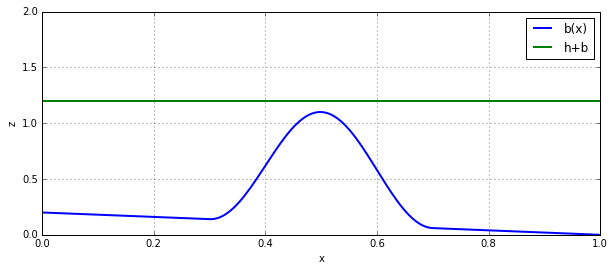

In [52]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 1)); ax.set_ylim((0, 2))
ax.set_xlabel("x");   ax.set_ylabel("z")

h = max(h_out, max(b)+0.1) - b
u = np.array([0.0 for xi in x])

lineb, = ax.plot(x, b, lw=2, label="b(x)")
linez, = ax.plot(x, b+h, lw=2, label="h+b")

ax.grid(True); ax.legend(loc="upper right");


In [56]:
W = np.array([h, h*u])

def init_bottom():
    linez.set_data(x, h)
    return (linez,)

def animate_bottom(it):
    dt = 1.e16
    for i in range(n):
        dt = min(dt, 0.8 * dx / sigma(W[:,i]))
    
    F[:,0] = np.array([q_in, q_in**2/W[H_,0] + 0.5*g*W[H_,0]**2])
    F[:,-1] = np.array([W[HU_,-1], W[HU_,-1]**2/h_out + g*h_out**2/2])
 
    for i in range(n-1):
        F[:,i+1] = HLL(W[:,i],W[:,i+1])
    
    for i in range(n):
        Q = [0.0, -g * W[H_,i] * bx[i] ]
        for k in range(2):
            W[k,i] = W[k,i] - dt / dx * (F[k,i+1]-F[k,i]) + dt * Q[k]
        
    linez.set_data(x, W[H_,:] + b)
    return (linez,)


In [57]:
animb = animation.FuncAnimation(fig, animate_bottom, init_func=init_bottom,
                               frames=1000, interval=50, blit=True, repeat=False)

In [58]:
HTML(animb.to_html5_video())